In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 4.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=a04dca6fcd95a6a0497dbe0bb45dae9e6bfa2d2a48dfafcd970760c842747c35
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [3]:
BTC = yf.download('BTC-USD',start='2016-01-01')['Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
sp500 = yf.download('^GSPC',start='2016-01-01')['Close']

[*********************100%***********************]  1 of 1 completed


In [5]:
BTC = pd.DataFrame.from_dict(BTC)
#Keep only the close column
BTC = BTC[['Close']]
#Rename the column name to BTC
BTC.columns = ['BTC']
BTC

,BTC
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991
...,...
2021-10-15,61593.949219
2021-10-16,60892.179688
2021-10-17,61553.617188


In [6]:
sp500 = pd.DataFrame.from_dict(sp500)
#Keep only the close column
sp500 = sp500[['Close']]
#Rename the column name to sp500
sp500.columns = ['sp500']
sp500

,sp500
Date,
2016-01-04,2012.660034
2016-01-05,2016.709961
2016-01-06,1990.260010
2016-01-07,1943.089966
2016-01-08,1922.030029
...,...
2021-10-12,4350.649902
2021-10-13,4363.799805
2021-10-14,4438.259766


In [7]:
SP500BTC = BTC.merge(sp500, how='inner',right_index = True, left_index=True)

In [8]:

SP500BTC.to_csv(r'SP500BTC.csv', index = False)

In [9]:
SP500BTC

,BTC,sp500
Date,,
2016-01-04,433.091003,2012.660034
2016-01-05,431.959991,2016.709961
2016-01-06,429.105011,1990.260010
2016-01-07,458.048004,1943.089966
2016-01-08,453.230011,1922.030029
...,...,...
2021-10-12,56041.058594,4350.649902
2021-10-13,57401.097656,4363.799805
2021-10-14,57321.523438,4438.259766


In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
window_size = 10

In [12]:
feature_column = 1
target_column = 1
X, y = window_data(SP500BTC, window_size, feature_column, target_column)

In [13]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [14]:

from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [15]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 9
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [18]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [19]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 9)             396       
_________________________________________________________________
dropout (Dropout)            (None, 10, 9)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 9)             684       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 9)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 9)                 684       
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [20]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=10, verbose=1)

Epoch 1/10
101/101 [==============================] - 5s 9ms/step - loss: 0.0051
Epoch 2/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0105
Epoch 3/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0088
Epoch 4/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0050
Epoch 5/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0032
Epoch 6/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 7/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0025
Epoch 8/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 9/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 10/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0018


In [21]:
# Evaluate the model
model.evaluate(X_test, y_test)

14/14 [==============================] - 1s 4ms/step - loss: 0.0138


0.013839189894497395

In [22]:
# Make some predictions
predicted = model.predict(X_test)

In [23]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = SP500BTC.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-01-24,3325.540039,3231.798340
2020-01-27,3295.469971,3238.134033
2020-01-28,3243.629883,3242.309570
2020-01-29,3276.239990,3245.755127
2020-01-30,3273.399902,3246.063477


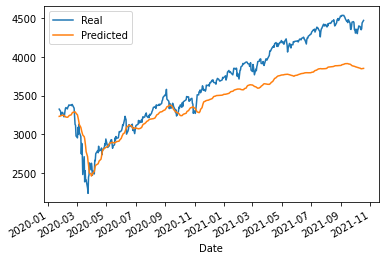

In [25]:
# Plot the real vs predicted values as a line chart
stocks.plot()